In [ ]:
# forecast_period_dates = pd.date_range('2019-01-01', '2021-12-31', freq='1d').tolist()

In [ ]:
# df1 = pd.DataFrame(forecast_period_dates, columns=['SOLDDATE'])

# Prophet

In [ ]:
# pymysql 인스톨
!pip install pymysql

     |████████████████████████████████| 43 kB 1.4 MB/s 


In [ ]:
# 필요한 모듈 임포트
import pandas as pd
import numpy as np
import pymysql
from fbprophet import Prophet

In [ ]:
# DB에 있는 테이블 불러와서 데이터프레임으로 만들기
conn = pymysql.connect(host='34.64.224.44', user='root', password='A412GBVSDsawe%$we', db='smart_factory')
sql_state='select * from `rawdata`'
df=pd.read_sql_query(sql_state, conn)

제품명 하나만 일단 예측 해 봄

In [ ]:
# prophet 알고리즘을 사용하기위한 데이터 전처리
df_hr1000 = df.loc[df['PRODNAME']=='PEMA-HR1000']
df_temp = df_hr1000[['SOLDDATE','QUANT']].groupby('SOLDDATE').sum().reset_index()
df_temp.columns = ['ds','y']

,SOLDDATE,CUSTID,PRODNAME,PRODCODE,REGION_U,TEMP_M,HUM_M,CONSTRUCTION,CONSTRUCTION_RATE,QUANT
2,2017-01-01,2004200.000000,PEMA-HR1000,PEMA013080012,경기도북부,0.005189,0.199493,0.216297,0.112057,6100.0
3,2017-01-01,2002100.000000,PEMA-HR1000,PEMA013125010,경상북도,0.005189,0.199493,0.216297,0.112057,6100.0
6,2017-01-01,2002500.000000,PEMA-HR1000,PEMA023033600,전라북도,0.005189,0.199493,0.216297,0.112057,6100.0
8,2017-01-01,2007000.000000,PEMA-HR1000,PEMA023024801,경기도남부,0.005189,0.199493,0.216297,0.112057,6100.0
9,2017-01-01,2002900.000000,PEMA-HR1000,PEMA033041500,경기도남부,0.005189,0.199493,0.216297,0.112057,6100.0


In [ ]:
# 훈련세트와 평가세트로 난누기
train = df_temp.loc[df_temp['ds'] <= '2020-12-31']
test = df_temp.loc[df_temp['ds'] >= '2021-01-01']['y']

In [ ]:
# 파라미터를 조정하지 않고 바로 Prophet으로 예측을 해봄.
# prophet object를 생성하고 훈련데이터를 피팅하여 prophet 모델을 만듬.
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=76)
forecast = m.predict(future)

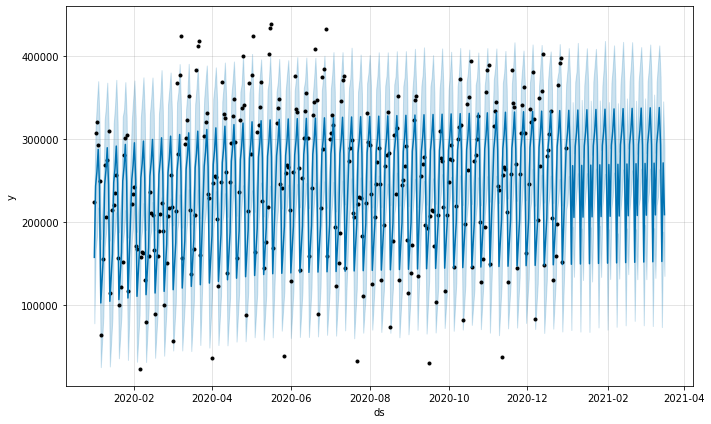

In [ ]:
# 파라미터 아무것도 설정 안해준 기본값들로도 패턴은 잡아냄.
fig1 = m.plot(forecast)

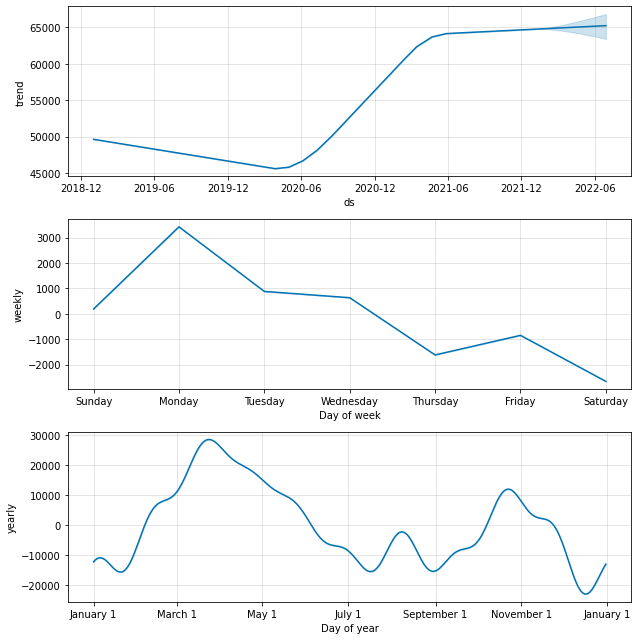

In [ ]:
# 피팅된 모델의 컴포넌트들을 시각화 해봄
fig2 = m.plot_components(forecast)

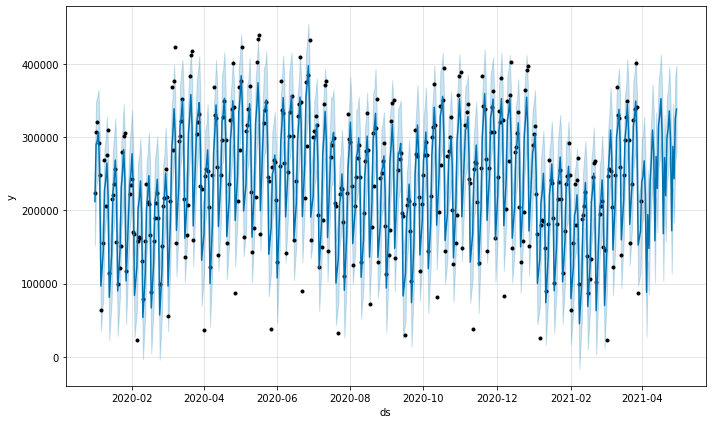

In [ ]:
# 여러가지 파라미터들을 변경하면서 최적을 찾아봄
m = Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality = 10,
    yearly_seasonality = 20,
    daily_seasonality = 10,
    seasonality_mode = 'multiplicative'
)

# Specifying Custom Seasonalities
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [ ]:
pred = forecast['yhat'][-76:]

In [ ]:
# 평가지표 수치들을 출력

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

def get_eval(Y_test,pred):
  MAE =  mean_absolute_error(Y_test, pred)
  MSE = mean_squared_error(Y_test, pred)
  RMSE = np.sqrt(MSE)
  # MSLE = mean_squared_log_error(Y_test, pred)
  # RMSLE = np.sqrt(mean_squared_log_error(Y_test, pred))
  R2 = r2_score(Y_test, pred)
  # return(f'MAE : {MAE}, MSE : {MSE}, RMSE : {RMSE}, MSEL : {MSLE}, RMSEL : {RMSLE}, R2 : {R2}')
  return(f'MAE : {MAE}, MSE : {MSE}, RMSE : {RMSE}, R2 : {R2}')

In [ ]:
get_eval(test,pred)

'MAE : 10.899119978330415, MSE : 174.28766876462814, RMSE : 13.201805511543796, R2 : -0.031798436911482986'